In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao', 'z']
ACTIVITIES = ['sit', 'walk', 'upstair', 'downstair']
TIME_START, TIME_END = 500, 6000
SAMPLING_RATE = 100  # hz
OVERLAP = 0.5 
CHUNK_SIZE = 1  # of seconds
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
EMB_SIZE = 128
NHEAD = 8
NHID = 128
NLAYERS = 3
DROPOUT = 0.1

In [2]:
def fetch_data(collection_name):
    """Fetch raw accelerometer data filtered by time and included people."""
    data_raw, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in INCLUDE_ONLY:
            continue

        for activity in ACTIVITIES:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                df = pd.DataFrame(record['acceleration'])
                if 'time' in df.columns:
                    df = df[(df['time'] >= TIME_START) & (df['time'] <= TIME_END)].drop(columns=['time'])
                    data_raw.append(df)
                    docs.append({'activity': activity})
    return data_raw, docs

In [3]:
def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    """Chunk raw acceleration data into overlapping windows with labels."""
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))

    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk[['x', 'y', 'z']].values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(data), np.array(labels)

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [5]:
class TransformerClassifier(nn.Module):
    def __init__(self, emb_size=EMB_SIZE, nhead=NHEAD, nhid=NHID, nlayers=NLAYERS, nclasses=len(ACTIVITIES), dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Linear(3, emb_size) 
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.classifier = nn.Linear(emb_size, nclasses)
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size) 
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  
        x = self.classifier(x)
        return x

In [8]:
def train_and_evaluate():
    print("Fetching all data...")
    data_raw_train, docs_train = fetch_data("training")
    data_raw_test, docs_test = fetch_data("testing")

    data_raw_all = data_raw_train + data_raw_test
    docs_all = docs_train + docs_test

    print(f"Total raw data entries: {len(data_raw_all)}")

    X_all, y_all = chunk_data_raw(data_raw_all, docs_all, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    print(f"All chunks: {X_all.shape}, All labels: {y_all.shape}")

    # 80/20 split
    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )

    print(f"Train chunks: {X_train.shape}, Train labels: {y_train.shape}")
    print(f"Val chunks: {X_val.shape}, Val labels: {y_val.shape}")

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = TransformerClassifier().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5) 

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item()
                predicted = preds.argmax(dim=1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(10,6))
    plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nClassification Report on Validation Set:")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES))

    cm = confusion_matrix(all_labels, all_preds)
    correct_counts = np.diag(cm)
    total_per_class = cm.sum(axis=1)
    accuracy_per_class = (correct_counts / total_per_class) * 100
    yticklabels_with_acc = [f"{act} ({accuracy_per_class[i]:.1f}%)" for i, act in enumerate(ACTIVITIES)]

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=ACTIVITIES, yticklabels=yticklabels_with_acc)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Transformer Model Confusion Matrix")
    plt.show()

Fetching all data...
Total raw data entries: 96
All chunks: (960, 100, 3), All labels: (960,)
Train chunks: (768, 100, 3), Train labels: (768,)
Val chunks: (192, 100, 3), Val labels: (192,)
Using device: cpu


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100 | Train Loss: 1.0654 | Val Loss: 0.8066
Epoch 2/100 | Train Loss: 0.7884 | Val Loss: 0.7070
Epoch 3/100 | Train Loss: 0.7270 | Val Loss: 0.7117
Epoch 4/100 | Train Loss: 0.6969 | Val Loss: 0.6029
Epoch 5/100 | Train Loss: 0.6292 | Val Loss: 0.5947
Epoch 6/100 | Train Loss: 0.6271 | Val Loss: 0.5734
Epoch 7/100 | Train Loss: 0.5217 | Val Loss: 0.5215
Epoch 8/100 | Train Loss: 0.4716 | Val Loss: 0.5140
Epoch 9/100 | Train Loss: 0.4428 | Val Loss: 0.5644
Epoch 10/100 | Train Loss: 0.4473 | Val Loss: 0.5564
Epoch 11/100 | Train Loss: 0.4254 | Val Loss: 0.4198
Epoch 12/100 | Train Loss: 0.3963 | Val Loss: 0.4312
Epoch 13/100 | Train Loss: 0.3824 | Val Loss: 0.4192
Epoch 14/100 | Train Loss: 0.3655 | Val Loss: 0.5086
Epoch 15/100 | Train Loss: 0.3585 | Val Loss: 0.4628
Epoch 16/100 | Train Loss: 0.3599 | Val Loss: 0.3849
Epoch 17/100 | Train Loss: 0.3400 | Val Loss: 0.4352
Epoch 18/100 | Train Loss: 0.3667 | Val Loss: 0.3601
Epoch 19/100 | Train Loss: 0.3207 | Val Loss: 0.4406
Ep

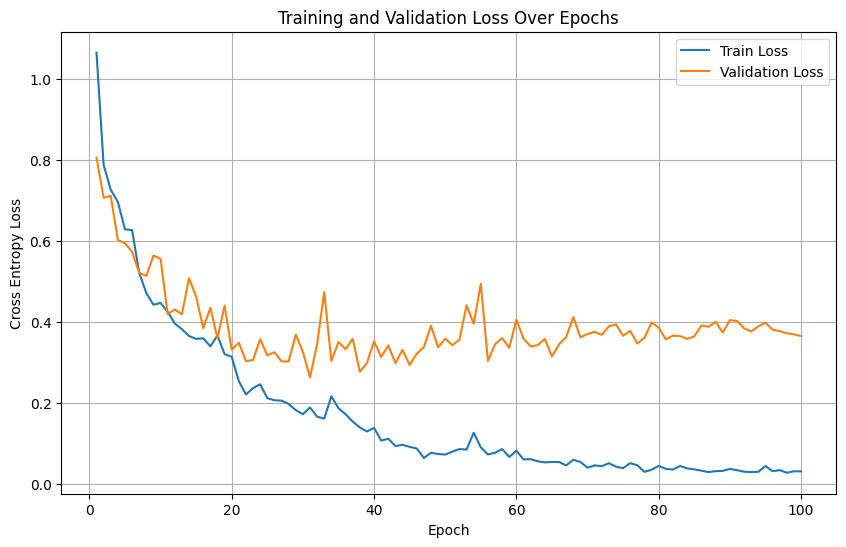


Classification Report on Validation Set:
              precision    recall  f1-score   support

         sit       1.00      1.00      1.00        48
        walk       0.90      0.96      0.93        48
     upstair       0.82      0.83      0.82        48
   downstair       0.84      0.77      0.80        48

    accuracy                           0.89       192
   macro avg       0.89      0.89      0.89       192
weighted avg       0.89      0.89      0.89       192



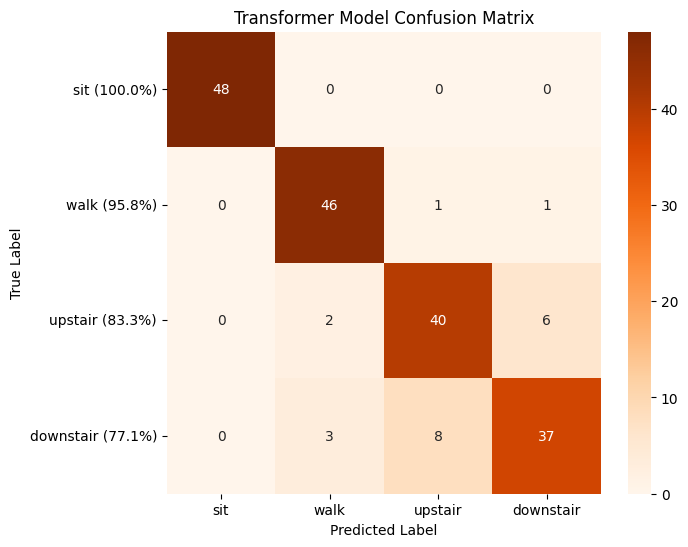

In [9]:
if __name__ == "__main__":
    train_and_evaluate()